# NOTES

1. I have a classificaiton problem as the target variable we are predicting is binary categorical.

2. EDA

    2.1 outliers removal using IQR

    2.2 missing values replaced with medians
    
    2.3 one-hot-encoding for categorical nominal variables
    
    2.4 ordinal encoding for categorical ordinal variables 
    
    2.4 Box-Cox transformation for continues variables
    
    2.5 interactions of continuous variables with male dummy, hypertension dummy, heart disease dummy
    
    2.6 included polynomial transformation (power of 2) for the continuous variables
    
    2.7 included a constant term
    
    2.8 balance the dataset resampling many positive stroke cases in order to have around 50% of sample with stroke=0 and 50% with stroke=1 because the original dataset had a frequency of positve strokes equal to 4.8%

3. pre-processing

4. Modeling. I have fitted 3 models, one linear, logistic regression, two non-linear, decisin tree and random forest, the latter it is also ensamble model. By studying the learning curve I have noticed that the PCA and the standard scaler were not needed, therefore all the models have been estimated without using PCA and standard scaler in their pipelines.

5. Model selection and validation. For each class of model, the best train/test split ratio has been decide studying the learning curve. All the estimations have been performed using a 5-fold cross-validation. For each model the best combination of parameters have been searched using grid-seach method.

6. model testing. All the models have been selected using the recall as relevant metric. In fact, the goal in this study is to minimize the number of false negative (FN), as they are much more dangerous for patients than false positive. A false negative case is when the model predicts the patient will not develop a storke, whereas in reality the patient will undergo a stroke. On the other hand, false positive are cases when the model predict a stroke, but the patient is actually not going to develop any stroke. In this context the model must be prudent, and avoid at all costs false negative, whereas false positive will no be that harmful. Recall, or sensitiviy, is measured as TP/(TP+FN), therefore maximizing recall is equivalent to minimizing the number of false negaive (FN).

7. Performance metrics. For each model, the confusion matrix is plotted to visualize the false positive, false negative, true positive, and true neagtive, together with the print of recall, precision, and f1 score. By the comparison of these metrics, it can be concluded that non-linear models (decisin tree and random forests) are superior to the linear model (logist regression) for this classification problem, as they both achieved a recall of 100%. However, random forest can also improve precision, from 92.9% for decision tree to 96.9%, without decreasing recall, making it the best model to predict strokes in this datset.

# SCRIPT

In [1]:
import sklearn as sk
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from scipy.special import boxcox1p
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
list(data.loc[:,"age"].unique())

[67.0,
 61.0,
 80.0,
 49.0,
 79.0,
 81.0,
 74.0,
 69.0,
 59.0,
 78.0,
 54.0,
 50.0,
 64.0,
 75.0,
 60.0,
 57.0,
 71.0,
 52.0,
 82.0,
 65.0,
 58.0,
 42.0,
 48.0,
 72.0,
 63.0,
 76.0,
 39.0,
 77.0,
 73.0,
 56.0,
 45.0,
 70.0,
 66.0,
 51.0,
 43.0,
 68.0,
 47.0,
 53.0,
 38.0,
 55.0,
 1.32,
 46.0,
 32.0,
 14.0,
 3.0,
 8.0,
 37.0,
 40.0,
 35.0,
 20.0,
 44.0,
 25.0,
 27.0,
 23.0,
 17.0,
 13.0,
 4.0,
 16.0,
 22.0,
 30.0,
 29.0,
 11.0,
 21.0,
 18.0,
 33.0,
 24.0,
 34.0,
 36.0,
 0.64,
 41.0,
 0.88,
 5.0,
 26.0,
 31.0,
 7.0,
 12.0,
 62.0,
 2.0,
 9.0,
 15.0,
 28.0,
 10.0,
 1.8,
 0.32,
 1.08,
 19.0,
 6.0,
 1.16,
 1.0,
 1.4,
 1.72,
 0.24,
 1.64,
 1.56,
 0.72,
 1.88,
 1.24,
 0.8,
 0.4,
 0.08,
 1.48,
 0.56,
 0.48,
 0.16]

{'whiskers': [<matplotlib.lines.Line2D at 0x261dd5e2a58>,
 'caps': [<matplotlib.lines.Line2D at 0x261dd5fc048>,
 'boxes': [<matplotlib.lines.Line2D at 0x261dd5e27f0>],
 'medians': [<matplotlib.lines.Line2D at 0x261dd5fc5f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x261dd5fc8d0>],
 'means': []}

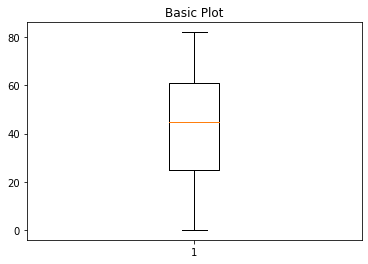

In [7]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data.loc[:,"age"])

{'whiskers': [<matplotlib.lines.Line2D at 0x261dd6d36a0>,
 'caps': [<matplotlib.lines.Line2D at 0x261dd6d3c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x261dd6d3438>],
 'medians': [<matplotlib.lines.Line2D at 0x261dd6e3240>],
 'fliers': [<matplotlib.lines.Line2D at 0x261dd6e3518>],
 'means': []}

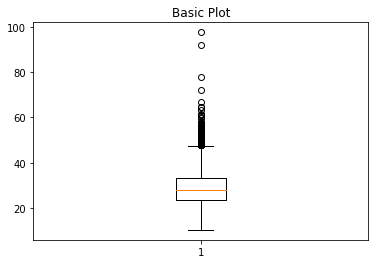

In [8]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data.loc[:,"bmi"].dropna())

We are going to exclude the outliers of bmi

In [9]:
def manualOutlierRemoval(df_in, colNames, upperLimits):


    df_out = df_in.copy()
    nvar = len(colNames)
    indx = []
    
    for i in range(nvar):
        
        col = colNames[i]
        upp = upperLimits[i]
        
        cond = (df_out[col] > upp)
        dinx = df_out[cond].index

        for item in list(dinx):
            indx.append(item)

        df_out.drop(dinx, inplace=True)

    return df_out, indx

def automaticOutlierRemoval(df_in, colNames):
 

    df_out = df_in.copy()

    for col in colNames:
        
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1

        fence_low  = q1 - 1.5*iqr
        fence_high = q3 + 1.5*iqr

        cond = (df_out[col] < fence_low) & (df_out[col] > fence_high)
        df_out.drop(df_out[cond].index, inplace=True)

    return df_out

In [10]:
data_without_outliers=automaticOutlierRemoval(data.dropna(subset=["bmi"]),["bmi"])
data_without_outliers

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [11]:
bmi_median = np.median(data_without_outliers.loc[:,"bmi"])

In [12]:
data.loc[:,"bmi"]=data.loc[:,"bmi"].fillna(bmi_median)
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [13]:
data=automaticOutlierRemoval(data.dropna(subset=["bmi"]),["age","bmi","avg_glucose_level"])
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [14]:
cat_vars = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status"]

for c in cat_vars:
    data.loc[:,c]=data.loc[:,c].astype("category")
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   category
 4   heart_disease      5110 non-null   category
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                5110 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   int64   
dtypes: category(7), float64(3), int64(2)
memory usage: 435.3 KB


In [15]:
data.loc[:,"smoking_status"].unique()

['formerly smoked', 'never smoked', 'smokes', 'Unknown']
Categories (4, object): ['formerly smoked', 'never smoked', 'smokes', 'Unknown']

In [16]:
oe=OrdinalEncoder(categories=[["Unknown","never smoked","formerly smoked", "smokes"]]) #here you list the values in the order you expect them
data.loc[:,"smoking_status"]=oe.fit_transform(np.array(data.loc[:,"smoking_status"]).reshape(-1,1)).astype(int)

In [17]:
cat_vars_nominal=["gender","ever_married","work_type","Residence_type"]

transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), cat_vars_nominal),
    remainder='passthrough')

transformed = transformer.fit_transform(data)

transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names()).astype(int)

data=transformed_df.copy()
data

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,id,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,1,0,1,0,1,0,0,1,9046,67,0,1,228,36,2,1
1,0,0,1,0,0,1,0,0,51676,61,0,0,202,28,1,1
2,1,0,1,0,1,0,0,0,31112,80,0,1,105,32,1,1
3,0,0,1,0,1,0,0,1,60182,49,0,0,171,34,3,1
4,0,0,1,0,0,1,0,0,1665,79,1,0,174,24,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,1,0,0,1,18234,80,1,0,83,28,1,0
5106,0,0,1,0,0,1,0,1,44873,81,0,0,125,40,1,0
5107,0,0,1,0,0,1,0,0,19723,35,0,0,82,30,1,0
5108,1,0,1,0,1,0,0,0,37544,51,0,0,166,25,2,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   onehotencoder__x0_Male           5110 non-null   int32
 1   onehotencoder__x0_Other          5110 non-null   int32
 2   onehotencoder__x1_Yes            5110 non-null   int32
 3   onehotencoder__x2_Never_worked   5110 non-null   int32
 4   onehotencoder__x2_Private        5110 non-null   int32
 5   onehotencoder__x2_Self-employed  5110 non-null   int32
 6   onehotencoder__x2_children       5110 non-null   int32
 7   onehotencoder__x3_Urban          5110 non-null   int32
 8   id                               5110 non-null   int32
 9   age                              5110 non-null   int32
 10  hypertension                     5110 non-null   int32
 11  heart_disease                    5110 non-null   int32
 12  avg_glucose_level                5110 non-null  

In [19]:
data=data.set_index("id")
data

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,,,,,
9046,1,0,1,0,1,0,0,1,67,0,1,228,36,2,1
51676,0,0,1,0,0,1,0,0,61,0,0,202,28,1,1
31112,1,0,1,0,1,0,0,0,80,0,1,105,32,1,1
60182,0,0,1,0,1,0,0,1,49,0,0,171,34,3,1
1665,0,0,1,0,0,1,0,0,79,1,0,174,24,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,0,0,1,0,1,0,0,1,80,1,0,83,28,1,0
44873,0,0,1,0,0,1,0,1,81,0,0,125,40,1,0
19723,0,0,1,0,0,1,0,0,35,0,0,82,30,1,0


In [20]:
data

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,,,,,
9046,1,0,1,0,1,0,0,1,67,0,1,228,36,2,1
51676,0,0,1,0,0,1,0,0,61,0,0,202,28,1,1
31112,1,0,1,0,1,0,0,0,80,0,1,105,32,1,1
60182,0,0,1,0,1,0,0,1,49,0,0,171,34,3,1
1665,0,0,1,0,0,1,0,0,79,1,0,174,24,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,0,0,1,0,1,0,0,1,80,1,0,83,28,1,0
44873,0,0,1,0,0,1,0,1,81,0,0,125,40,1,0
19723,0,0,1,0,0,1,0,0,35,0,0,82,30,1,0


In [21]:
features = ["bmi","age","avg_glucose_level"]


feat_skew = data[features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' : feat_skew})
skewness


Skew in numerical features: 



,Skew
avg_glucose_level,1.570849
bmi,1.084674
age,-0.140384


In [22]:
extreme_vars = list(skewness.loc[skewness.loc[:,"Skew"]>1,"Skew"].index)
extreme_vars

['avg_glucose_level', 'bmi']

In [23]:
lam = 0.5
for var in extreme_vars:    
    data.loc[data[var]!=0, var] =  boxcox1p(data[var], lam) 

In [24]:
#features behave normally
normal_vars = [s for s in features if s not in extreme_vars]
normal_vars

['age']

In [25]:
for var in normal_vars:
    data[var] =  boxcox1p(data[var], lam)

In [26]:
data

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,,,,,
9046,1,0,1,0,1,0,0,1,14.492423,0,1,28.265492,10.165525,2,1
51676,0,0,1,0,0,1,0,0,13.748016,0,0,26.495614,8.770330,1,1
31112,1,0,1,0,1,0,0,0,16.000000,0,1,18.591260,9.489125,1,1
60182,0,0,1,0,1,0,0,1,12.142136,0,0,24.229754,9.832160,3,1
1665,0,0,1,0,0,1,0,0,15.888544,1,0,24.457513,8.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,0,0,1,0,1,0,0,1,16.000000,1,0,16.330303,8.770330,1,0
44873,0,0,1,0,0,1,0,1,16.110770,0,0,20.449944,10.806248,1,0
19723,0,0,1,0,0,1,0,0,10.000000,0,0,16.220867,9.135529,1,0


In [27]:
data.loc[:,"onehotencoder__x0_Male_x_age"]=data.loc[:,"onehotencoder__x0_Male"]*data.loc[:,"age"]
data.loc[:,"onehotencoder__x0_Male_x_bmi"]=data.loc[:,"onehotencoder__x0_Male"]*data.loc[:,"bmi"]
data.loc[:,"onehotencoder__x0_Male_x_avg_glucose_level"]=data.loc[:,"onehotencoder__x0_Male"]*data.loc[:,"avg_glucose_level"]

data.loc[:,"hypertension_x_age"]=data.loc[:,"hypertension"]*data.loc[:,"age"]
data.loc[:,"hypertension_x_bmi"]=data.loc[:,"hypertension"]*data.loc[:,"bmi"]
data.loc[:,"hypertension_x_avg_glucose_level"]=data.loc[:,"hypertension"]*data.loc[:,"avg_glucose_level"]

data.loc[:,"heart_disease_x_age"]=data.loc[:,"heart_disease"]*data.loc[:,"age"]
data.loc[:,"heart_disease_x_bmi"]=data.loc[:,"heart_disease"]*data.loc[:,"bmi"]
data.loc[:,"heart_disease_x_avg_glucose_level"]=data.loc[:,"heart_disease"]*data.loc[:,"avg_glucose_level"]


In [28]:
data.loc[:,"constant"]=1
data.loc[:,"age2"]=data.loc[:,"age"]**2
data.loc[:,"avg_glucose_level2"]=data.loc[:,"avg_glucose_level"]**2
data.loc[:,"bmi2"]=data.loc[:,"bmi"]**2

In [29]:
data.describe()

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,onehotencoder__x0_Male_x_age,onehotencoder__x0_Male_x_bmi,onehotencoder__x0_Male_x_avg_glucose_level,hypertension_x_age,hypertension_x_bmi,hypertension_x_avg_glucose_level,heart_disease_x_age,heart_disease_x_bmi,heart_disease_x_avg_glucose_level,constant,age2,avg_glucose_level2,bmi2
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.0,5110.000000,5110.000000,5110.000000
mean,0.413894,0.000196,0.656164,0.004305,0.572407,0.160274,0.134442,0.508023,10.695096,0.097456,0.054012,18.271300,8.762306,1.179843,0.048728,4.344361,3.611900,7.667922,1.344390,0.920157,1.976579,0.786473,0.488207,1.125095,1.0,130.080672,349.548069,78.674456
std,0.492578,0.013989,0.475034,0.065480,0.494778,0.366896,0.341160,0.499985,3.962154,0.296607,0.226063,3.963679,1.377253,1.029961,0.215320,5.836586,4.380258,9.504487,4.133156,2.831243,6.225593,3.312041,2.053460,4.867044,0.0,75.057107,165.330455,25.282119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.966630,4.633250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,168.133482,21.467002
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.198039,0.000000,0.000000,15.663522,7.797959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,67.207844,245.345913,60.808164
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,11.564660,0.000000,0.000000,17.183326,8.770330,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,133.741360,295.266696,76.918682
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,13.748016,0.000000,0.000000,19.447611,9.489125,2.000000,0.000000,10.328828,8.583005,16.654758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,189.007937,378.209558,90.043499
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.220867,1.000000,1.000000,30.984845,17.798990,3.000000,1.000000,16.220867,17.798990,30.984845,16.220867,17.798990,30.984845,16.220867,12.832397,30.984845,1.0,263.116531,960.060620,316.804041


In [30]:
data.describe()

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,onehotencoder__x0_Male_x_age,onehotencoder__x0_Male_x_bmi,onehotencoder__x0_Male_x_avg_glucose_level,hypertension_x_age,hypertension_x_bmi,hypertension_x_avg_glucose_level,heart_disease_x_age,heart_disease_x_bmi,heart_disease_x_avg_glucose_level,constant,age2,avg_glucose_level2,bmi2
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.0,5110.000000,5110.000000,5110.000000
mean,0.413894,0.000196,0.656164,0.004305,0.572407,0.160274,0.134442,0.508023,10.695096,0.097456,0.054012,18.271300,8.762306,1.179843,0.048728,4.344361,3.611900,7.667922,1.344390,0.920157,1.976579,0.786473,0.488207,1.125095,1.0,130.080672,349.548069,78.674456
std,0.492578,0.013989,0.475034,0.065480,0.494778,0.366896,0.341160,0.499985,3.962154,0.296607,0.226063,3.963679,1.377253,1.029961,0.215320,5.836586,4.380258,9.504487,4.133156,2.831243,6.225593,3.312041,2.053460,4.867044,0.0,75.057107,165.330455,25.282119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.966630,4.633250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,168.133482,21.467002
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.198039,0.000000,0.000000,15.663522,7.797959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,67.207844,245.345913,60.808164
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,11.564660,0.000000,0.000000,17.183326,8.770330,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,133.741360,295.266696,76.918682
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,13.748016,0.000000,0.000000,19.447611,9.489125,2.000000,0.000000,10.328828,8.583005,16.654758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,189.007937,378.209558,90.043499
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.220867,1.000000,1.000000,30.984845,17.798990,3.000000,1.000000,16.220867,17.798990,30.984845,16.220867,17.798990,30.984845,16.220867,12.832397,30.984845,1.0,263.116531,960.060620,316.804041


In [31]:
strokes=data.loc[data.loc[:,"stroke"]==1,:]
for i in range(1,18):
    data=pd.concat([data, strokes], axis=0)
data=pd.concat([data, strokes.iloc[:130]], axis=0)
data

,onehotencoder__x0_Male,onehotencoder__x0_Other,onehotencoder__x1_Yes,onehotencoder__x2_Never_worked,onehotencoder__x2_Private,onehotencoder__x2_Self-employed,onehotencoder__x2_children,onehotencoder__x3_Urban,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,onehotencoder__x0_Male_x_age,onehotencoder__x0_Male_x_bmi,onehotencoder__x0_Male_x_avg_glucose_level,hypertension_x_age,hypertension_x_bmi,hypertension_x_avg_glucose_level,heart_disease_x_age,heart_disease_x_bmi,heart_disease_x_avg_glucose_level,constant,age2,avg_glucose_level2,bmi2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9046,1,0,1,0,1,0,0,1,14.492423,0,1,28.265492,10.165525,2,1,14.492423,10.165525,28.265492,0.000000,0.00000,0.000000,14.492423,10.165525,28.265492,1,210.030310,798.938032,103.337900
51676,0,0,1,0,0,1,0,0,13.748016,0,0,26.495614,8.770330,1,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,189.007937,702.017545,76.918682
31112,1,0,1,0,1,0,0,0,16.000000,0,1,18.591260,9.489125,1,1,16.000000,9.489125,18.591260,0.000000,0.00000,0.000000,16.000000,9.489125,18.591260,1,256.000000,345.634959,90.043499
60182,0,0,1,0,1,0,0,1,12.142136,0,0,24.229754,9.832160,3,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,147.431458,587.080984,96.671362
1665,0,0,1,0,0,1,0,0,15.888544,1,0,24.457513,8.000000,1,1,0.000000,0.000000,0.000000,15.888544,8.00000,24.457513,0.000000,0.000000,0.000000,1,252.445825,598.169948,64.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50522,0,0,1,0,0,0,0,1,15.088007,0,0,20.978251,8.770330,1,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,227.647970,440.086998,76.918682
3352,1,0,1,0,0,1,0,1,15.776389,1,0,17.390719,8.770330,2,1,15.776389,8.770330,17.390719,15.776389,8.77033,17.390719,0.000000,0.000000,0.000000,1,248.894445,302.437122,76.918682
70943,0,0,1,0,1,0,0,1,16.000000,0,0,15.204651,8.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1,256.000000,231.181398,64.000000


# PRE-PROCESSING AND MODELING

In [32]:
X =np.array(data.loc[:,[c for c in list(data.columns) if c != "stroke"]])
X.shape

y=data.loc[:,["stroke"]].values.reshape(data.shape[0],)
y

array([1, 1, 1, ..., 1, 1, 1])

## LOGISTIC REGRESSION

### PIPELINES

In [33]:
scaler = StandardScaler()

pca = PCA(n_components=10) 

lr = LogisticRegression(random_state=1, solver='lbfgs', max_iter=10000) #change here the model

pipe_lr_pca_scaler = make_pipeline(scaler,pca,lr)

pipe_lr_scaler = make_pipeline(scaler,lr)

pipe_lr_pca = make_pipeline(pca,lr)

pipe_lr = make_pipeline(lr)

### LEARNING CURVES

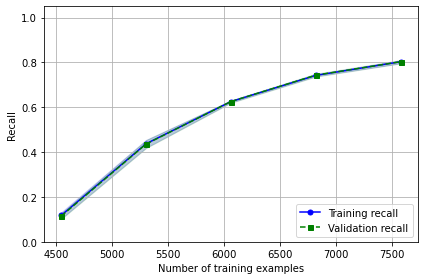

In [34]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr_pca_scaler,
                                                           X=X,
                                                           y=y,
                                                           scoring='recall',
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=5,
                                                           n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training recall')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation recall')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

### GRID SEARCH

In [36]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.10, random_state=1, stratify=y, shuffle=True)

param_range = param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalties=["l1", "l2","elsaticnet"]

param_grid = [{'logisticregression__C': param_range,
               'logisticregression__solver': solvers,
              'logisticregression__penalty':penalties
              }]

gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,
                  scoring="recall",
                  cv=5,
                  refit=True,
                  n_jobs=-1)
              
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8113253012048194
{'logisticregression__C': 100.0, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


### BEST MODEL ESTIMATION

precision score: 0.7236842105263158
recall (sensitivity) score: 0.8333333333333334
f1 score: 0.7746478873239436


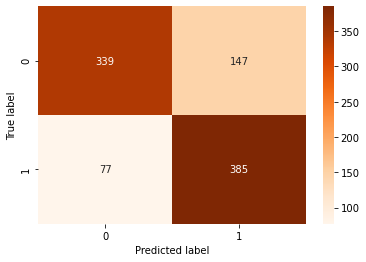

In [37]:
lr=LogisticRegression(random_state=1,
                      solver=gs.best_params_["logisticregression__solver"],
                      C=gs.best_params_["logisticregression__C"],
                      penalty=gs.best_params_["logisticregression__penalty"],
                      max_iter=1000)

pipe_lr_best_config = make_pipeline(lr)

#now we fit the pipe:
pipe_lr_best_config.fit(X_train, y_train)
y_test_pred = pipe_lr_best_config.predict(X_test)

print("precision score: {}".format(precision_score(y_test, y_test_pred)))
print("recall (sensitivity) score: {}".format(recall_score(y_test, y_test_pred)))
print("f1 score: {}".format(f1_score(y_test, y_test_pred)))

cm = confusion_matrix(y_test, y_test_pred)

ax = sn.heatmap(cm, cmap='Oranges', annot=True, fmt='g')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## DECISION TREE

### PIPELINES

In [38]:
scaler = StandardScaler()

pca = PCA(n_components=10) 

dt = tree.DecisionTreeClassifier(random_state=1, criterion="gini", splitter="best")

pipe_dt_pca_scaler = make_pipeline(scaler,pca,lr)

pipe_dt_scaler = make_pipeline(scaler,lr)

pipe_dt_pca = make_pipeline(pca,lr)

pipe_dt = make_pipeline(dt)

### LEARNING CURVES

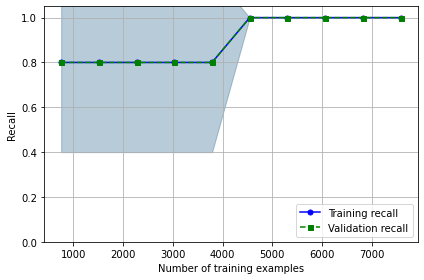

In [39]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_dt,
                                                           X=X,
                                                           y=y,
                                                           scoring='recall',
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=5,
                                                           n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training recall')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation recall')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

### GRID SEARCH

In [40]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.40, random_state=1, stratify=y, shuffle=True)

criterion_range = ["gini", "entropy", "log_loss"]
splliter_range = ["best","random"]
max_features=["auto", "sqrt", "log2"] 

param_grid = [{'decisiontreeclassifier__criterion': criterion_range,
               'decisiontreeclassifier__splitter': splliter_range,
              'decisiontreeclassifier__max_features':max_features,
              }]

gs = GridSearchCV(estimator=pipe_dt,
                  param_grid=param_grid,
                  scoring="recall",
                  cv=5,
                  refit=True,
                  n_jobs=-1)
              
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

1.0
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__splitter': 'best'}


### BEST MODEL ESTIMATION

precision score: 0.9290030211480362
recall (sensitivity) score: 1.0
f1 score: 0.9631949882537196


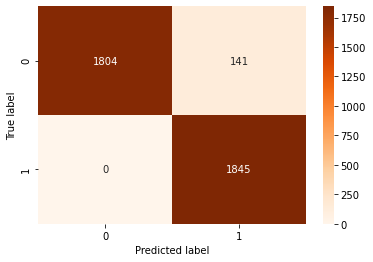

In [41]:
dt=tree.DecisionTreeClassifier(random_state=1,
                      criterion=gs.best_params_["decisiontreeclassifier__criterion"],
                      splitter=gs.best_params_["decisiontreeclassifier__splitter"],
                      max_features=gs.best_params_["decisiontreeclassifier__max_features"])

# pipe_dt_best_config = make_pipeline(dt)

#now we fit the pipe:
dt=dt.fit(X_train, y_train)
y_test_pred = dt.predict(X_test)

print("precision score: {}".format(precision_score(y_test, y_test_pred)))
print("recall (sensitivity) score: {}".format(recall_score(y_test, y_test_pred)))
print("f1 score: {}".format(f1_score(y_test, y_test_pred)))

cm = confusion_matrix(y_test, y_test_pred)

ax = sn.heatmap(cm, cmap='Oranges', annot=True, fmt='g')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [42]:
# tree.plot_tree(dt)

## RANDOM FOREST

### PIPELINES

In [43]:
scaler = StandardScaler()

pca = PCA(n_components=10) 

rf = RandomForestClassifier(random_state=1, criterion="gini")

pipe_rf_pca_scaler = make_pipeline(scaler,pca,rf)

pipe_rf_scaler = make_pipeline(scaler,rf)

pipe_rf_pca = make_pipeline(pca,rf)

pipe_rf = make_pipeline(rf)

### LEARNING CURVES

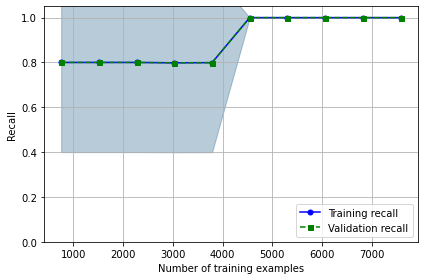

In [44]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rf,
                                                           X=X,
                                                           y=y,
                                                           scoring='recall',
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=5,
                                                           n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training recall')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation recall')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

### GRID SEARCH

In [45]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.40, random_state=1, stratify=y, shuffle=True)

criterion_range = ["gini", "entropy", "log_loss"]
max_features=["sqrt", "log2"] 

param_grid = [{'randomforestclassifier__criterion': criterion_range,
              'randomforestclassifier__max_features':max_features,
              }]

gs = GridSearchCV(estimator=pipe_rf,
                  param_grid=param_grid,
                  scoring="recall",
                  cv=5,
                  refit=True,
                  n_jobs=-1)
              
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

1.0
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'sqrt'}


### BEST MODEL ESTIMATION

precision score: 0.9690126050420168
recall (sensitivity) score: 1.0
f1 score: 0.984262469991998


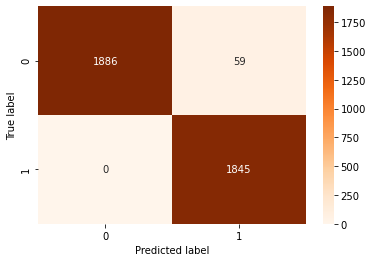

In [49]:
rf=RandomForestClassifier(random_state=1,
                      criterion=gs.best_params_["randomforestclassifier__criterion"],
                      max_features=gs.best_params_["randomforestclassifier__max_features"])

pipe_rf_best_config = make_pipeline(rf)

#now we fit the pipe:
pipe_rf_best_config.fit(X_train, y_train)
y_test_pred = pipe_rf_best_config.predict(X_test)

print("precision score: {}".format(precision_score(y_test, y_test_pred)))
print("recall (sensitivity) score: {}".format(recall_score(y_test, y_test_pred)))
print("f1 score: {}".format(f1_score(y_test, y_test_pred)))

cm = confusion_matrix(y_test, y_test_pred)

ax = sn.heatmap(cm, cmap='Oranges', annot=True, fmt='g')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()